In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import plotnine as p9

plt.style.use('ggplot') # set the theme for plots
mpl.rcParams['figure.figsize'] = (10,8)
datadir = "../data/CollegeScorecard"

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the 2009 data
COL = pd.read_csv(datadir + '/MERGED2009_10_PP.csv')

In [3]:
# Which columns have no NAs
col_dna = COL.dropna(axis=1)
col_dna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7149 entries, 0 to 7148
Data columns (total 15 columns):
UNITID       7149 non-null int64
OPEID        7149 non-null object
OPEID6       7149 non-null int64
INSTNM       7149 non-null object
CITY         7149 non-null object
STABBR       7149 non-null object
ZIP          7149 non-null object
MAIN         7149 non-null int64
NUMBRANCH    7149 non-null int64
PREDDEG      7149 non-null int64
HIGHDEG      7149 non-null int64
CONTROL      7149 non-null int64
ST_FIPS      7149 non-null int64
REGION       7149 non-null int64
ICLEVEL      7149 non-null int64
dtypes: int64(10), object(5)
memory usage: 837.9+ KB


In [4]:
col_dtypes = dict(col_dna.dtypes.replace(np.dtype('int64'),np.dtype('float64'))) # make the dtypes floats
col_dtypes['UNITID'] = np.dtype('int64') # convert the UNITID back to int
vars_interest = ['ADM_RATE','UGDS','TUITIONFEE_IN','TUITIONFEE_OUT','MN_EARN_WNE_P10'] # Include these vars
col_dtypes.update({a: np.dtype('float64') for a in vars_interest}) # make them floats

In [5]:
## Try reading it again
col_try_again = pd.read_csv(datadir + '/MERGED2009_10_PP.csv',na_values='PrivacySuppressed',
                            dtype=col_dtypes,usecols=col_dtypes.keys())
col_try_again.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7149 entries, 0 to 7148
Data columns (total 20 columns):
UNITID             7149 non-null int64
OPEID              7149 non-null object
OPEID6             7149 non-null float64
INSTNM             7149 non-null object
CITY               7149 non-null object
STABBR             7149 non-null object
ZIP                7149 non-null object
MAIN               7149 non-null float64
NUMBRANCH          7149 non-null float64
PREDDEG            7149 non-null float64
HIGHDEG            7149 non-null float64
CONTROL            7149 non-null float64
ST_FIPS            7149 non-null float64
REGION             7149 non-null float64
ADM_RATE           2774 non-null float64
UGDS               6596 non-null float64
TUITIONFEE_IN      4263 non-null float64
TUITIONFEE_OUT     4115 non-null float64
MN_EARN_WNE_P10    5486 non-null float64
ICLEVEL            7149 non-null float64
dtypes: float64(14), int64(1), object(5)
memory usage: 1.1+ MB


In [6]:
col_try_again['Year'] = pd.Period('2010',freq='Y')

In [7]:
def read_cs_data(year,col_dtypes,datadir):
    """read a CollegeScorecard dataframe"""
    nextyr = str(int(year) + 1)[-2:]
    filename = datadir + '/MERGED{}_{}_PP.csv'.format(year,nextyr)
    col = pd.read_csv(filename,na_values='PrivacySuppressed',
                      dtype=col_dtypes,usecols=col_dtypes.keys())
    col['Year'] = pd.Period(str(int(year) + 1),freq='Y')
    return col

In [8]:
col = pd.concat((read_cs_data(str(y),col_dtypes,datadir) for y in range(1996,2017)))
col = col.set_index(['UNITID','Year'])

In [10]:
col_large = col[col['UGDS'] > 1000]
davis = col_large.query('CITY=="Davis" and STABBR=="CA"')
davis = davis.reset_index(level=0)

In [11]:
davis['YearDT'] = davis.index.to_timestamp()

In [12]:
col_large = col_large.reset_index(level=1) 
col_large['YearDT'] = pd.PeriodIndex(col_large['Year']).to_timestamp()
col_large.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48362 entries, 100636 to 489201
Data columns (total 21 columns):
Year               48362 non-null object
OPEID              48362 non-null object
OPEID6             48362 non-null float64
INSTNM             48362 non-null object
CITY               48362 non-null object
STABBR             48362 non-null object
ZIP                48362 non-null object
MAIN               48362 non-null float64
NUMBRANCH          48362 non-null float64
PREDDEG            48362 non-null float64
HIGHDEG            48362 non-null float64
CONTROL            48362 non-null float64
ST_FIPS            48362 non-null float64
REGION             48362 non-null float64
ADM_RATE           21041 non-null float64
UGDS               48362 non-null float64
TUITIONFEE_IN      37823 non-null float64
TUITIONFEE_OUT     37825 non-null float64
MN_EARN_WNE_P10    12528 non-null float64
ICLEVEL            48362 non-null float64
YearDT             48362 non-null datetime64[ns]
dt

In [13]:
dav_id = davis.loc['1997','UNITID'] # store davis id
col_gby = col_large.groupby(level=0) # Group by the university ID
enough_dat = col_gby.count()['TUITIONFEE_IN'] > 15 # Select those with more than 15 non-missing entries
p = .1 # select a sampling probability
in_sample = pd.Series(np.random.binomial(1,p,size=enough_dat.shape[0]) > 0,
                     index=enough_dat.index.values) # 

In [14]:
def samp_with_dav(col_large,p=.1):
    col_gby = col_large.groupby(level=0)
    enough_dat = col_gby.count()['TUITIONFEE_IN'] > 15
    in_sample = pd.Series(np.random.binomial(1,p,size=enough_dat.shape[0]) > 0,
                     index=enough_dat.index.values)
    in_sample.index.name = 'UNITID'
    col_samp = col_large[in_sample & enough_dat]
    col_dav = col_large.loc[dav_id].reset_index()
    col_dav['UNITID'] = dav_id
    col_dav = col_dav.set_index('UNITID')
    return pd.concat([col_samp,col_dav])

In [15]:
col_samp = samp_with_dav(col_large)

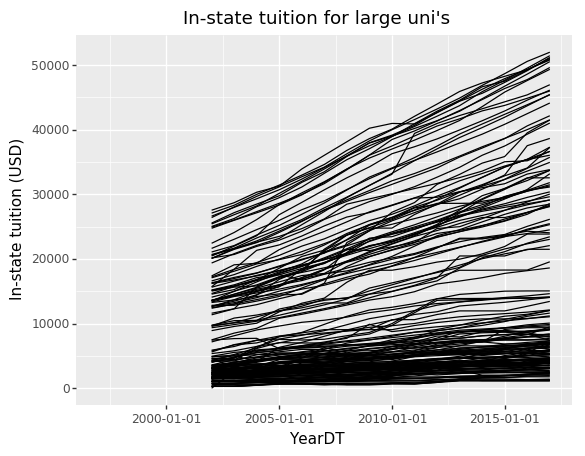

<ggplot: (-9223363283061514552)>

In [16]:
p9.ggplot(col_samp.reset_index()) \
+ p9.aes('YearDT','TUITIONFEE_IN',group='UNITID') \
+ p9.geom_line() \
+ p9.labels.ggtitle("In-state tuition for large uni's") \
+ p9.labels.ylab('In-state tuition (USD)')

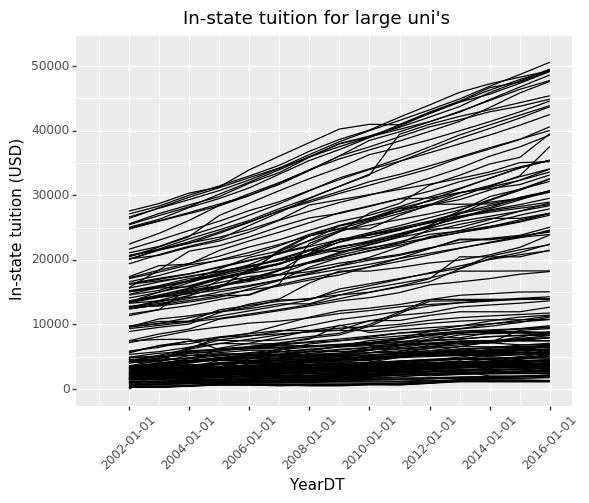

<ggplot: (8753793308897)>

In [17]:
p9.ggplot(col_samp.reset_index()) \
+ p9.aes('YearDT','TUITIONFEE_IN',group='UNITID') \
+ p9.geom_line() \
+ p9.theme(axis_text_x = p9.themes.element_text(rotation=45)) \
+ p9.labels.ggtitle("In-state tuition for large uni's") \
+ p9.labels.ylab('In-state tuition (USD)') \
+ p9.scale_x_date(limits=['2001','2016']) 

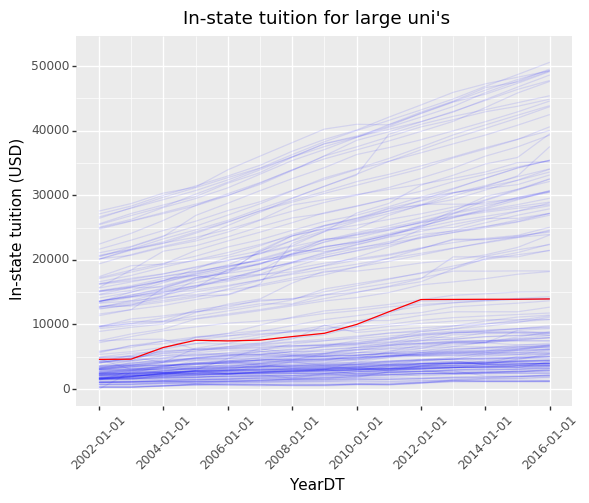

<ggplot: (-9223363283065341387)>

In [20]:
p9.ggplot(col_samp.reset_index()) \
+ p9.aes('YearDT','TUITIONFEE_IN',group='UNITID') \
+ p9.geom_line(alpha=.1,color='b') + p9.scale_x_date(limits=['2002','2016']) \
+ p9.theme(axis_text_x = p9.themes.element_text(rotation=45)) \
+ p9.labels.ggtitle("In-state tuition for large uni's") \
+ p9.labels.ylab('In-state tuition (USD)') \
+ p9.geom_line(data=davis,color='r') # new layer!

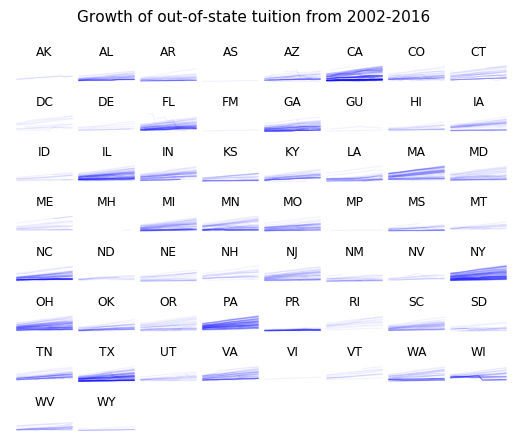

<ggplot: (-9223363283061514629)>

In [21]:
p9.ggplot(col_large.reset_index()) \
+ p9.aes('YearDT','TUITIONFEE_OUT',group='UNITID') \
+ p9.geom_line(alpha=.05,color='b') + p9.scale_x_date(limits=['2002','2016']) \
+ p9.theme_void() + p9.labels.ggtitle("Growth of out-of-state tuition from 2002-2016") \
+ p9.facet_wrap('~ STABBR',ncol=8)

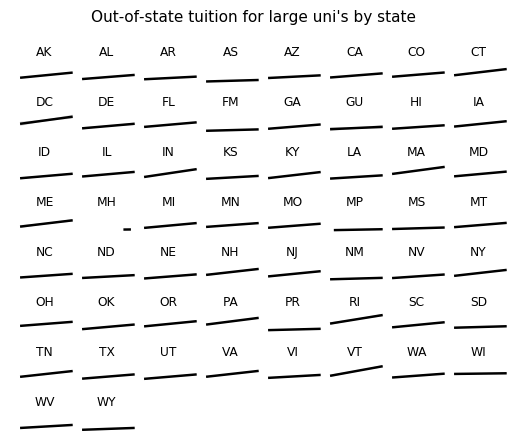

<ggplot: (-9223363269320014304)>

In [31]:
p9.ggplot(col_large.reset_index()) \
+ p9.aes('YearDT','TUITIONFEE_OUT',group='STABBR') \
+ p9.scale_x_date(limits=['2001','2016']) \
+ p9.facet_wrap('~ STABBR',ncol=8) \
+ p9.stat_smooth(method='lm') \
+ p9.theme_void() \
+ p9.labels.ggtitle("Out-of-state tuition for large uni's by state") \
+ p9.labels.ylab('Out-of-state tuition')

In [22]:
col_2013 = col_large.query('YearDT == "2013-01-01"')

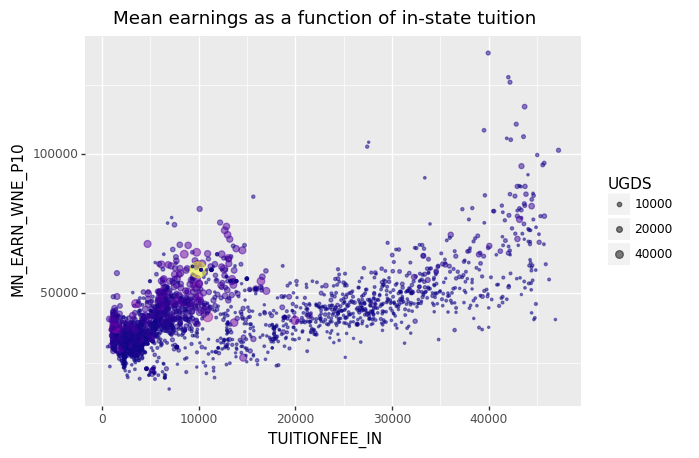

<ggplot: (8753789513487)>

In [23]:
p9.ggplot(col_2013) + p9.aes('TUITIONFEE_IN','MN_EARN_WNE_P10',size='UGDS',color='UGDS')\
+ p9.scale_size_area(breaks=[10000,20000,40000]) \
+ p9.labels.ggtitle("Mean earnings as a function of in-state tuition") \
+ p9.geom_point(alpha=.5) + p9.scale_color_cmap('plasma',guide=False)

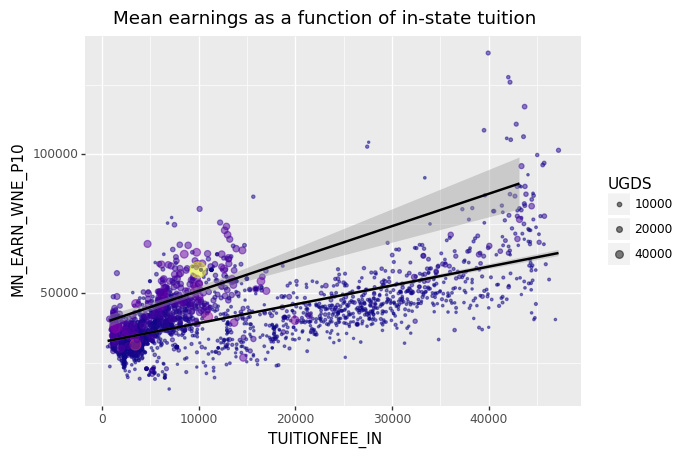

<ggplot: (-9223363283065262311)>

In [24]:
p9.ggplot(col_2013) + p9.aes('TUITIONFEE_IN','MN_EARN_WNE_P10',size='UGDS',
                             color='UGDS',groups='UGDS > 20000')\
+ p9.scale_size_area(breaks=[10000,20000,40000]) \
+ p9.labels.ggtitle("Mean earnings as a function of in-state tuition") \
+ p9.geom_point(alpha=.5) + p9.stat_smooth(show_legend=False) + p9.scale_color_cmap('plasma',guide=False)

In [25]:
col_2013_nna = col_2013[~col_2013['TUITIONFEE_IN'].isna()]
col_2013_nna = col_2013_nna[col_2013_nna['HIGHDEG'] != 0]

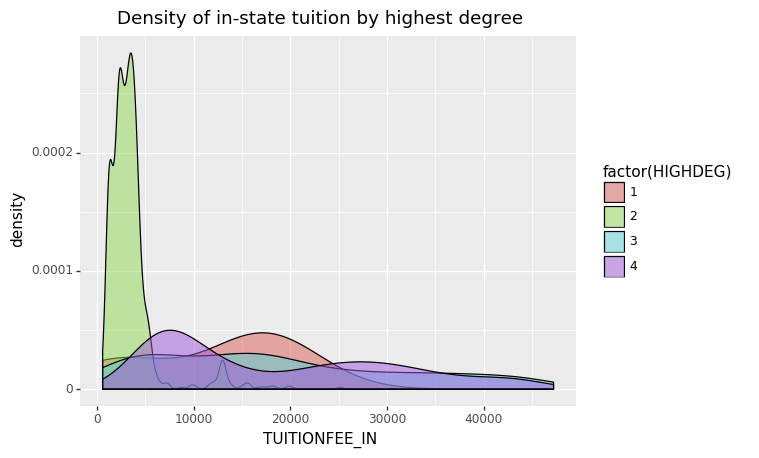

<ggplot: (-9223363283061514503)>

In [26]:
p9.ggplot(col_2013_nna) + p9.aes('TUITIONFEE_IN',fill='factor(HIGHDEG)') \
+ p9.geom_density(alpha=.5) + p9.labels.ggtitle('Density of in-state tuition by highest degree')

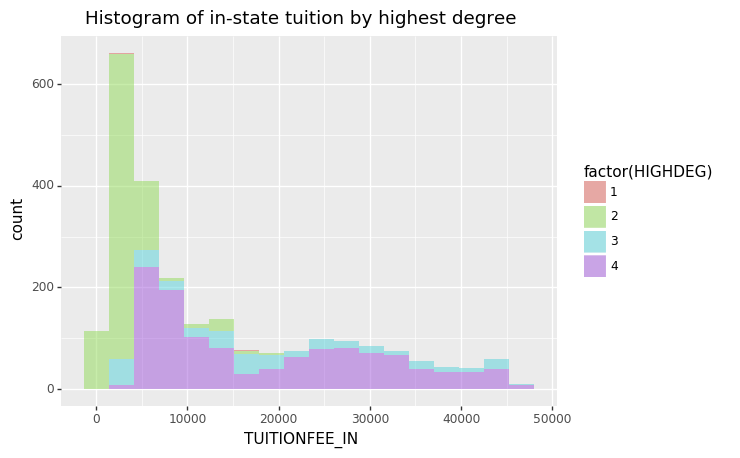

<ggplot: (-9223363283085824729)>

In [29]:
p9.ggplot(col_2013_nna) + p9.aes('TUITIONFEE_IN',fill='factor(HIGHDEG)') \
+ p9.geom_histogram(alpha=.5) + p9.labels.ggtitle('Histogram of in-state tuition by highest degree')

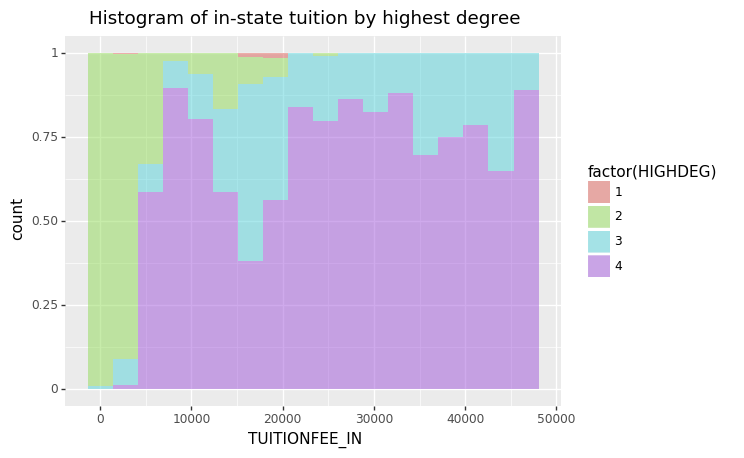

<ggplot: (8753768951265)>

In [32]:
p9.ggplot(col_2013_nna) + p9.aes('TUITIONFEE_IN',fill='factor(HIGHDEG)') \
+ p9.geom_histogram(alpha=.5,position='fill') \
+ p9.labels.ggtitle('Histogram of in-state tuition by highest degree')

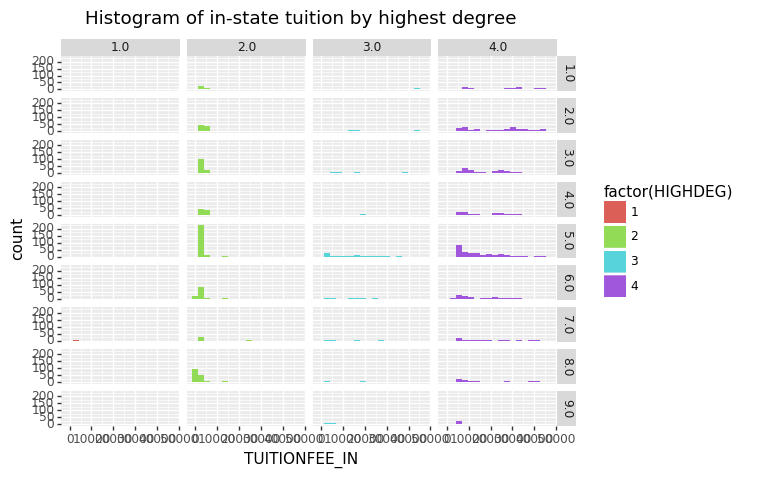

<ggplot: (8753768907233)>

In [37]:
p9.ggplot(col_2013_nna) + p9.aes('TUITIONFEE_IN',fill='factor(HIGHDEG)') \
+ p9.geom_histogram() \
+ p9.facet_grid('REGION ~ HIGHDEG') \
+ p9.labels.ggtitle('Histogram of in-state tuition by highest degree')

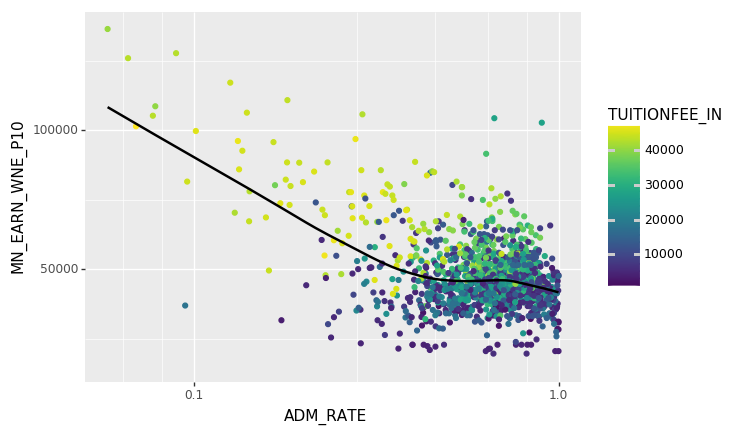

<ggplot: (8738146242017)>

In [42]:
p9.ggplot(col_2013_nna) + p9.aes('ADM_RATE','MN_EARN_WNE_P10',color='TUITIONFEE_IN') \
+ p9.geom_point() + p9.scale_x_log10() \
+ p9.scale_color_cmap() + p9.stat_smooth(method='lowess')

![](Confounding.PNG)

Confounding variables:
- when measuring dependence between two variables, a confounder is a variable associated with both
- (undirected) graphical model: two variables are connected if they are dependent even when conditioning on all other variables
- (directed) graphical model: variable is independent of ancestors when conditioning on parents